In [409]:
import h5py
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [410]:
cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]

In [411]:
#### EXPERIMENTS WITH SAMPLES SPLIT BY INDIVIDUAL --- Supplementary Figure 11d  ###############
# transformation_folder_train = '../../Pipeline_Outputs_Submitted/origGE_rev/last_shared_layer_transformations_TRAIN/'
# transformation_folder_test = '../../Pipeline_Outputs_Submitted/origGE_rev/last_shared_layer_transformations/'


transformation_folder_train = '../../Pipeline_Outputs_Submitted/origGE/last_shared_layer_transformations_TRAIN/'
transformation_folder_test = '../../Pipeline_Outputs_Submitted/origGE/last_shared_layer_transformations/'
path_to_gs_data = "../../DATA/geneset_data/"

gmt_locations = {"REACTOME": path_to_gs_data + 'c2.all.v7.0.symbols_JustR.gmt',
                "KEGG": path_to_gs_data + 'c2.all.v7.0.symbols_JustK.gmt',
                "HALLMARK": path_to_gs_data + 'h.all.v7.0.symbols.gmt'}
for gset in ["mathys_celltypes", "sara_modules", "ben_modules", "mathys_microglia", "zhang_modules"]:
    gmt_locations[gset] = '%s%s/processed/gene_set.gmt'%(path_to_gs_data,gset)
    
##### DATA ######
# path_to_cv_indices = "../../DATA/MTL_data_rev/CV_INDICES/"
path_to_cv_indices = "../../DATA/MTL_data/CV_INDICES/"
merged_phenotypes_df= pd.read_csv("../../DATA/MTL_data/merged_phenotypes.csv")


# path_to_final_models_chosen = "../../Pipeline_Outputs_Submitted/origGE_rev/final_models_chosen/"
path_to_final_models_chosen = "../../Pipeline_Outputs_Submitted/origGE/final_models_chosen/"

MTL_FINAL_MODELS = pickle.load(open(path_to_final_models_chosen + "MTL/folds.p", "rb" ) )
MLP_BASELINES_FINAL_MODELS = pickle.load(open(path_to_final_models_chosen + "MLP_baselines/folds.p", "rb" ) )

# path_to_data_PCAsplit =  "../../DATA/MTL_data_rev/ACT_MSBBRNA_ROSMAP_PCASplit/"
# path_to_MDAD_data =   "../../DATA/MTL_data_rev/ACT_MSBBRNA_ROSMAP.h5"
path_to_data_PCAsplit =  "../../DATA/MTL_data/ACT_MSBBRNA_ROSMAP_PCASplit/"
path_to_MDAD_data =   "../../DATA/MTL_data/ACT_MSBBRNA_ROSMAP.h5"

###########################################################################################
#### EXPERIMENTS WHERE WE CONTROL FOR PMI/RIN --- Supplementary Figure 11b  ###############
###########################################################################################

# transformation_folder_train = "/media/big/nbbwang/AD_Project/analyses/MTL_variable_tasks/6vars-continuous/last_shared_layer_transformations_TRAIN/resid_01_GE_PmiRin/"
# transformation_folder_test = "/media/big/nbbwang/AD_Project/analyses/MTL_variable_tasks/6vars-continuous/last_shared_layer_transformations/resid_01_GE_PmiRin/"
# path_to_gs_data = "../../DATA/geneset_data/"

# gmt_locations = {"REACTOME": path_to_gs_data + 'c2.all.v7.0.symbols_JustR.gmt',
#                 "KEGG": path_to_gs_data + 'c2.all.v7.0.symbols_JustK.gmt',
#                 "HALLMARK": path_to_gs_data + 'h.all.v7.0.symbols.gmt'}
# for gset in ["mathys_celltypes", "sara_modules", "ben_modules", "mathys_microglia", "zhang_modules"]:
#     gmt_locations[gset] = '%s%s/processed/gene_set.gmt'%(path_to_gs_data,gset)
    
# path_to_cv_indices = "../../DATA/MTL_data/CV_INDICES/"
# merged_phenotypes_df= pd.read_csv("../../DATA/MTL_data/merged_phenotypes.csv")

# path_to_final_models_chosen = "/media/big/nbbwang/AD_Project/analyses/MTL_variable_tasks/6vars-continuous/resid_01_GE_PmiRin/final_models_chosen/"
# MTL_FINAL_MODELS = pickle.load(open(path_to_final_models_chosen + "MTL/folds.p", "rb" ) )
# MLP_BASELINES_FINAL_MODELS = pickle.load(open(path_to_final_models_chosen + "MLP_baselines/folds.p", "rb" ) )

# path_to_data_PCAsplit =  "/media/big/nbbwang/AD_Project/analyses/MTL_variable_tasks/MTL_data/resid_01_GE_PmiRin/ACT_MSBBRNA_ROSMAP_PCASplit/"
# path_to_MDAD_data =   "/media/big/nbbwang/AD_Project/analyses/MTL_variable_tasks/MTL_data/resid_01_GE_PmiRin/ACT_MSBBRNA_ROSMAP.h5"

In [412]:
with h5py.File(path_to_MDAD_data, 'r') as hf:
    all_ge = hf["ge"][:]
    print(list(hf.keys()))

['ge', 'gene_symbols', 'labels', 'labels_names']


In [413]:
scaling_factor = {"BRAAK": 5, "CERAD": 3, "PLAQUES": 1, "TANGLES": 1, "ABETA_IHC":1, "TAU_IHC":1}

In [414]:
def generate_geneset_embeddings(ge_df, gmt_file):
    gmt = pd.read_csv(gmt_file, header=None)
    gmt["names"] = gmt[0].apply(lambda x: x.split("\t")[0])
    gmt["genes"] = gmt[0].apply(lambda x: x.split("\t")[2:])
    
    
    ge_gset_df = pd.DataFrame(index=ge_df.index)
    
    for gset_i,row in gmt.iterrows():
        name = row["names"]
        genes_in_gs = np.intersect1d(np.array(row["genes"]), gene_symbols)
        ge_gset_df[name] = np.mean(ge_df[genes_in_gs],axis=1)
        
    return(ge_gset_df)


# Training phenotypes

In [415]:
methods = ["MD-AD"] + ["BRAAK", "CERAD", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"] + ["PCA", "KMeans"] +["ben_modules", "sara_modules", "zhang_modules"]
metrics = ["CERAD", "PLAQUES",  "ABETA_IHC", "BRAAK",  "TANGLES", "TAU_IHC"]

In [416]:


CORRECTED_PVALS = {}
CORRCOEFFS = {}
MIN_PVALS = {}

for transformation in methods:
    print(transformation)
    CORRECTED_PVALS[transformation] = {}
    CORRCOEFFS[transformation] = {}
    MIN_PVALS[transformation] = {}

    for fold in range(25, 30):

        CORRECTED_PVALS[transformation][fold] = {}
        CORRCOEFFS[transformation][fold] = {}
        MIN_PVALS[transformation][fold] = {}


        
        if transformation in ["ben_modules", "sara_modules", "zhang_modules"]:
            train_indices = np.loadtxt(path_to_cv_indices + "%i/train_indices.txt"%fold, dtype=int)
            test_indices = np.loadtxt(path_to_cv_indices + "%i/valid_indices.txt"%fold, dtype=int)
            labels_names = np.loadtxt(path_to_cv_indices + "%i/labels_names.txt"%fold, dtype=str)
            train_labels = np.loadtxt(path_to_cv_indices + "%i/train_labels.txt"%fold, dtype=str)
            labels = np.loadtxt(path_to_cv_indices + "%i/valid_labels.txt"%fold, dtype=str)
            gene_symbols = np.loadtxt(path_to_cv_indices + "%i/gene_symbols.txt"%fold,dtype=str)
            ge_train = all_ge[train_indices]
            ge_valid = all_ge[test_indices]

    
            train_outputs = generate_geneset_embeddings(pd.DataFrame(ge_train, columns=gene_symbols), gmt_locations[transformation]).values
            outputs = generate_geneset_embeddings(pd.DataFrame(ge_valid, columns=gene_symbols), gmt_locations[transformation]).values

        else:

            if transformation=="MD-AD":
                transformed_path_train = '%sMTL/%s/%i.h5'%(transformation_folder_train, MTL_FINAL_MODELS[fold], fold)
                transformed_path_test = '%sMTL/%s/%i.h5'%(transformation_folder_test, MTL_FINAL_MODELS[fold], fold)
            elif transformation in ["PCA", "KMeans"]:
                transformed_path_train = '%sunsupervised_methods/%s/%i.h5'%(transformation_folder_train, transformation, fold)
                transformed_path_test = '%sunsupervised_methods/%s/%i.h5'%(transformation_folder_test, transformation, fold)
            else:
                fname = MLP_BASELINES_FINAL_MODELS[fold][transformation]            
                transformed_path_train = '%sMLP_baselines/%s/%s/%i.h5'%(transformation_folder_train, fname, transformation, fold)
                transformed_path_test = '%sMLP_baselines/%s/%s/%i.h5'%(transformation_folder_test, fname, transformation, fold)

            with h5py.File(transformed_path_train, 'r') as hf:
                train_outputs = hf["outputs"][:]
                train_labels =hf["labels"][:]

            with h5py.File(transformed_path_test, 'r') as hf:
                outputs = hf["outputs"][:]
                labels =hf["labels"][:]
                labels_names =hf["labels_names"][:].astype(str)

        train_labels_df = pd.DataFrame(train_labels, columns=labels_names)
        labels_df = pd.DataFrame(labels, columns=labels_names)
        non_triv_idx = np.where(np.sum(np.abs(outputs),axis=0) > 0)[0]
        
        
        for phenotype in metrics:
            train_label_vals = train_labels_df[phenotype].values.astype(float)/scaling_factor[phenotype]
            train_non_nan_idx = np.where(~np.isnan(train_label_vals))[0]
            
            label_vals = labels_df[phenotype].values.astype(float)/scaling_factor[phenotype]
            non_nan_idx = np.where(~np.isnan(label_vals))[0]

            
            train_pvals_uncorrected = []
            for feat in non_triv_idx:
                corrcoeff, p = stats.pearsonr(train_outputs[train_non_nan_idx,feat], train_label_vals[train_non_nan_idx])
                train_pvals_uncorrected.append(p)

            
            corrcoeffs = []
            pvals_uncorrected = []
            for feat in non_triv_idx:
                corrcoeff, p = stats.pearsonr(outputs[non_nan_idx,feat], label_vals[non_nan_idx])
                corrcoeffs.append(corrcoeff)
                pvals_uncorrected.append(p)
            corrected = sm.stats.multipletests(pvals_uncorrected, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]


            CORRECTED_PVALS[transformation][fold][phenotype] =corrected
            CORRCOEFFS[transformation][fold][phenotype] =corrcoeffs
            MIN_PVALS[transformation][fold][phenotype] = corrected[np.argmin(train_pvals_uncorrected)]

MD-AD


/home/nbbwang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


BRAAK
CERAD
PLAQUES
TANGLES
ABETA_IHC
TAU_IHC
PCA
KMeans
ben_modules
sara_modules
zhang_modules


In [417]:
MIN_PVALS_mean_over_5folds_neglog10 = {}
MIN_PVALS_stderr_over_5folds_neglog10 = {}
for method in MIN_PVALS.keys():
    MIN_PVALS_mean_over_5folds_neglog10[method] = {}
    MIN_PVALS_stderr_over_5folds_neglog10[method] = {}

    for metric in metrics:
        MIN_PVALS_mean_over_5folds_neglog10[method][metric] = np.mean(-np.log10([MIN_PVALS[method][fold][metric] for fold in range(25,30)]))
        MIN_PVALS_stderr_over_5folds_neglog10[method][metric] = stats.sem(-np.log10([MIN_PVALS[method][fold][metric] for fold in range(25,30)]))
        
        
MIN_PVALS_groups = {}
for method in MIN_PVALS.keys():
    MIN_PVALS_groups[method] = {}
    for phen in MIN_PVALS[method][25].keys():
        MIN_PVALS_groups[method][phen] = []
        for fold in range(25,30):
            MIN_PVALS_groups[method][phen].append(MIN_PVALS[method][fold][phen])

### Sourcedata

In [419]:
sourcedata_trainingphens = []

for i,methods in enumerate(methods_groups):
    for method in methods:
        tmp = pd.DataFrame.from_dict(MIN_PVALS[method])
        tmp = tmp.T
        tmp["test_set"] = tmp.index-24
        if i==2:
            tmp["model"] = method + "_MLP"
        else:
            tmp["model"] = method
        sourcedata_trainingphens.append(tmp)
        
sourcedata_trainingphens = pd.concat(sourcedata_trainingphens)
newcols = ["model", "test_set"]+metrics
sourcedata_trainingphens = sourcedata_trainingphens[newcols]

/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


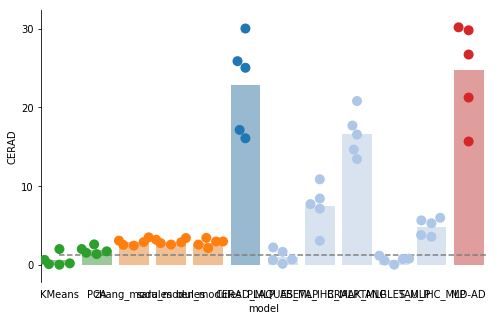

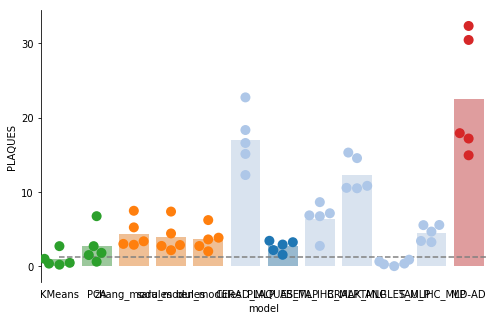

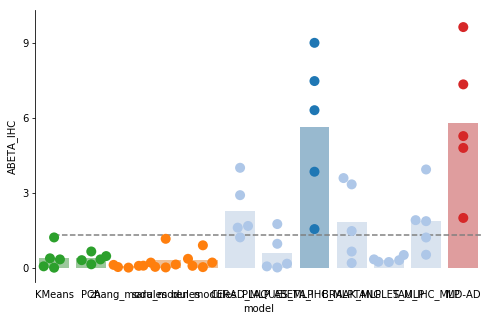

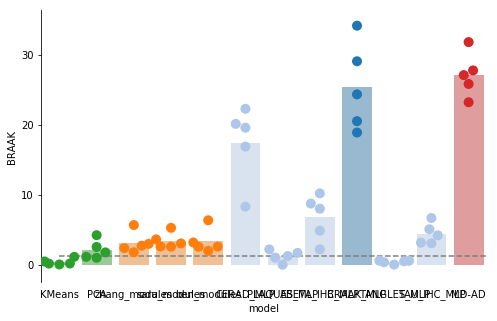

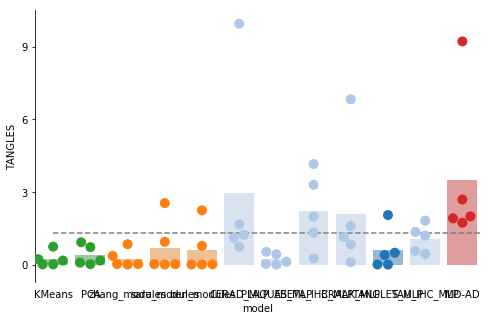

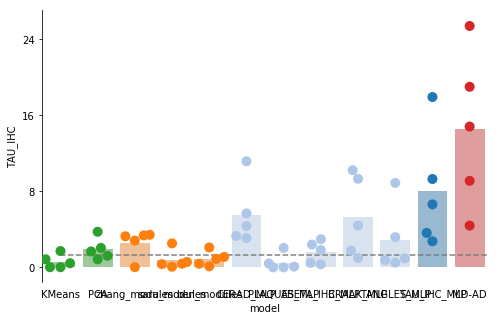

In [421]:

for yvar in metrics:
    tmp = sourcedata[["model", "test_set", yvar]]
    tmp[yvar] = tmp[yvar].apply(lambda x: -np.log10(x))

    f, ax = plt.subplots(1,1,figsize=(8,5))
    g=sns.catplot(x="model", y=yvar, hue="model",aspect=1,
                  kind="swarm", data=tmp, 
                  hue_order=sourcedata_highlevelphens["model"].unique(),
                  palette=colors_tr_phens[yvar],ax=ax, s=10);

    g=sns.barplot(x="model", y=yvar, hue="model",
                   data=tmp, 
                  hue_order=sourcedata_highlevelphens["model"].unique(),
                  palette=colors_tr_phens[yvar], ax=ax, ci=None, alpha=.5, dodge=False);

    ax.get_legend().remove()

    ax.hlines(-np.log10(.05), 0, most_items*len(methods_groups), color="gray", linestyle="--")


    ax.grid(False)
    # Show graphic
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_facecolor("None")

    ax.yaxis.set_major_locator(plt.MaxNLocator(4, integer=True))

    ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True, color="#000000")

    plt.close(2)
    plt.close(3)
    plt.show()



# Other phenotypes

In [422]:
def get_merged_fold(labels, labels_names, merged_phens_df):
    labels_df = pd.DataFrame(labels, columns=labels_names)
    merged_df = pd.DataFrame(labels_df[["sample_name", "filename"]].values.astype(str), columns=["sample_name","filename"])
    merged_df = merged_df.merge(merged_phenotypes_df, on=["sample_name", "filename"], how="left")
    return merged_df

In [423]:
methods = ["MD-AD"] + ["BRAAK", "CERAD", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"] + ["PCA", "KMeans"] + ["ben_modules", "sara_modules", "zhang_modules"]
metrics = ['dementia',  'addx_to_death_cats','controlled_cogn_global_last']

In [424]:

CORRECTED_PVALS = {}
CORRCOEFFS = {}
MIN_PVALS = {}
node_vals = {}
label_vals_dict = {}


for trans_i, transformation in enumerate(methods):
    print(transformation)
    CORRECTED_PVALS[transformation] = {}
    CORRCOEFFS[transformation] = {}
    MIN_PVALS[transformation] = {}
    node_vals[transformation] = {}



    for fold in range(25, 30):

        CORRECTED_PVALS[transformation][fold] = {}
        CORRCOEFFS[transformation][fold] = {}
        MIN_PVALS[transformation][fold] = {}
        node_vals[transformation][fold] = {}
        label_vals_dict[fold]={}

        
        
        if transformation in ["ben_modules", "sara_modules", "zhang_modules"]:
            train_indices = np.loadtxt(path_to_cv_indices + "%i/train_indices.txt"%fold, dtype=int)
            test_indices = np.loadtxt(path_to_cv_indices + "%i/valid_indices.txt"%fold, dtype=int)
            labels_names = np.loadtxt(path_to_cv_indices + "%i/labels_names.txt"%fold, dtype=str)
            train_labels = np.loadtxt(path_to_cv_indices + "%i/train_labels.txt"%fold, dtype=str)
            labels = np.loadtxt(path_to_cv_indices + "%i/valid_labels.txt"%fold, dtype=str)
            gene_symbols = np.loadtxt(path_to_cv_indices + "%i/gene_symbols.txt"%fold,dtype=str)
            ge_train = all_ge[train_indices]
            ge_valid = all_ge[test_indices]


            train_outputs = generate_geneset_embeddings(pd.DataFrame(ge_train, columns=gene_symbols), gmt_locations[transformation]).values
            outputs = generate_geneset_embeddings(pd.DataFrame(ge_valid, columns=gene_symbols), gmt_locations[transformation]).values

        else:

            if transformation=="MD-AD":
                transformed_path_train = '%sMTL/%s/%i.h5'%(transformation_folder_train, MTL_FINAL_MODELS[fold], fold)
                transformed_path_test = '%sMTL/%s/%i.h5'%(transformation_folder_test, MTL_FINAL_MODELS[fold], fold)
            elif transformation in ["PCA", "KMeans"]:
                transformed_path_train = '%sunsupervised_methods/%s/%i.h5'%(transformation_folder_train, transformation, fold)
                transformed_path_test = '%sunsupervised_methods/%s/%i.h5'%(transformation_folder_test, transformation, fold)
            else:
                fname = MLP_BASELINES_FINAL_MODELS[fold][transformation]            
                transformed_path_train = '%sMLP_baselines/%s/%s/%i.h5'%(transformation_folder_train, fname, transformation, fold)
                transformed_path_test = '%sMLP_baselines/%s/%s/%i.h5'%(transformation_folder_test, fname, transformation, fold)

            with h5py.File(transformed_path_train, 'r') as hf:
                train_outputs = hf["outputs"][:]
                train_labels =hf["labels"][:]

            with h5py.File(transformed_path_test, 'r') as hf:
                outputs = hf["outputs"][:]
                labels =hf["labels"][:]
                labels_names =hf["labels_names"][:].astype(str)
        
        train_merged_phenotypes = get_merged_fold(labels, labels_names, merged_phenotypes_df)
        train_merged_phenotypes = train_merged_phenotypes.replace("90+", "90")

        merged_phenotypes = get_merged_fold(labels, labels_names, merged_phenotypes_df)
        merged_phenotypes = merged_phenotypes.replace("90+", "90")


        train_labels_df = pd.DataFrame(train_labels, columns=labels_names)
    
        labels_df = pd.DataFrame(labels, columns=labels_names)
        non_triv_idx = np.where(np.sum(np.abs(outputs),axis=0) > 0)[0]

        for metric in metrics:
            train_label_vals = train_merged_phenotypes[metric].values.astype(float)
            train_non_nan_idx = np.where(~np.isnan(train_label_vals))[0]
            
            label_vals = merged_phenotypes[metric].values.astype(float)
            non_nan_idx = np.where(~np.isnan(label_vals))[0]
#             print(non_nan_idx.shape)


            train_pvals_uncorrected = []
            for feat in non_triv_idx:
                corrcoeff, p = stats.pearsonr(train_outputs[train_non_nan_idx,feat], train_label_vals[train_non_nan_idx])
                train_pvals_uncorrected.append(p)


            corrcoeffs = []
            pvals_uncorrected = []
            for feat in non_triv_idx:
                corrcoeff, p = stats.pearsonr(outputs[non_nan_idx,feat], label_vals[non_nan_idx])
                corrcoeffs.append(corrcoeff)
                pvals_uncorrected.append(p)
            corrected = sm.stats.multipletests(pvals_uncorrected, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]


            CORRECTED_PVALS[transformation][fold][metric] =corrected
            CORRCOEFFS[transformation][fold][metric] =corrcoeffs
#             MIN_PVALS[MLP_phenotype][fold][metric] = corrected[np.argmin(train_pvals_uncorrected)]
            MIN_PVALS[transformation][fold][metric] = np.min(corrected)
            node_vals[transformation][fold][metric] = outputs[non_nan_idx,non_triv_idx[np.argmin(corrected)]]
            label_vals_dict[fold][metric] = label_vals[non_nan_idx]
            
            


MD-AD


/home/nbbwang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


BRAAK
CERAD
PLAQUES
TANGLES
ABETA_IHC
TAU_IHC
PCA
KMeans
ben_modules
sara_modules
zhang_modules


In [425]:
MIN_PVALS_mean_over_5folds_neglog10 = {}
MIN_PVALS_stderr_over_5folds_neglog10 = {}
for method in MIN_PVALS.keys():
    MIN_PVALS_mean_over_5folds_neglog10[method] = {}
    MIN_PVALS_stderr_over_5folds_neglog10[method] = {}

    for metric in metrics:
        MIN_PVALS_mean_over_5folds_neglog10[method][metric] = np.mean(-np.log10([MIN_PVALS[method][fold][metric] for fold in range(25,30)]))
        MIN_PVALS_stderr_over_5folds_neglog10[method][metric] = stats.sem(-np.log10([MIN_PVALS[method][fold][metric] for fold in range(25,30)]))
        
MIN_PVALS_groups = {}
for method in MIN_PVALS.keys():
    MIN_PVALS_groups[method] = {}
    for phen in MIN_PVALS[method][25].keys():
        MIN_PVALS_groups[method][phen] = []
        for fold in range(25,30):
            MIN_PVALS_groups[method][phen].append(MIN_PVALS[method][fold][phen])

### Sourcedata

In [427]:
sourcedata_highlevelphens = []

for i,methods in enumerate(methods_groups):
    for method in methods:
        tmp = pd.DataFrame.from_dict(MIN_PVALS[method])
        tmp = tmp.T
        tmp["test_set"] = tmp.index-24
        if i==2:
            tmp["model"] = method + "_MLP"
        else:
            tmp["model"] = method
        sourcedata_highlevelphens.append(tmp)
        
sourcedata_highlevelphens = pd.concat(sourcedata_highlevelphens)
sourcedata = sourcedata_trainingphens.merge(sourcedata_highlevelphens, on=["test_set", "model"])
sourcedata.to_csv("sourcedata/3ab_embedding_correlations.csv", index=False)

### Bar charts with points

/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


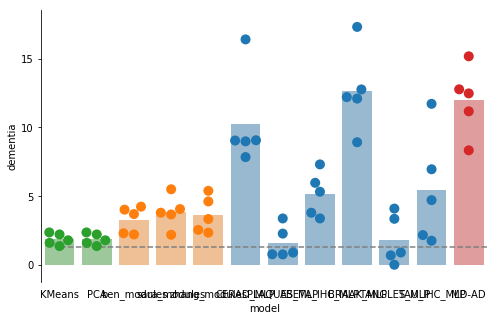

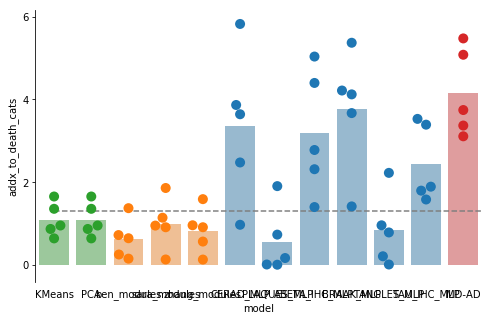

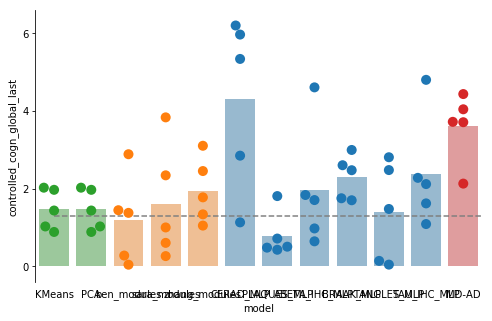

In [428]:

for yvar in metrics:
    tmp = sourcedata_highlevelphens[["model", "test_set", yvar]]
    tmp[yvar] = tmp[yvar].apply(lambda x: -np.log10(x))

    f, ax = plt.subplots(1,1,figsize=(8,5))
    g=sns.catplot(x="model", y=yvar, hue="model",aspect=1,
                  kind="swarm", data=tmp, 
                  hue_order=sourcedata_highlevelphens["model"].unique(),
                  palette=colors,ax=ax, s=10);

    g=sns.barplot(x="model", y=yvar, hue="model",
                   data=tmp, 
                  hue_order=sourcedata_highlevelphens["model"].unique(),
                  palette=colors, ax=ax, ci=None, alpha=.5, dodge=False);

    ax.get_legend().remove()

    ax.hlines(-np.log10(.05), 0, most_items*len(methods_groups), color="gray", linestyle="--")


    ax.grid(False)
    # Show graphic
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_facecolor("None")

    ax.yaxis.set_major_locator(plt.MaxNLocator(4, integer=True))

    ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True, color="#000000")
    
    plt.close(2)
    plt.close(3)
    plt.show()
